<a href="https://colab.research.google.com/github/shubham-kanodia/pose-tracking/blob/main/Pose_Tracker_Simplified.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Installation

In [1]:
%%capture
!python -m pip install mediapipe

## Setup

In [2]:
import mediapipe as mp
from mediapipe.tasks import python
from mediapipe.tasks.python import vision

from glob import glob

In [4]:
!wget -O pose_landmarker.task -q https://storage.googleapis.com/mediapipe-models/pose_landmarker/pose_landmarker_heavy/float16/1/pose_landmarker_heavy.task

In [3]:
model_path = './pose_landmarker.task'

In [5]:
from mediapipe import solutions
from mediapipe.framework.formats import landmark_pb2
import numpy as np


def draw_landmarks_on_image(rgb_image, pose_landmarks_list):
  annotated_image = np.copy(rgb_image)

  for idx in range(len(pose_landmarks_list)):
    pose_landmarks = pose_landmarks_list[idx]

    pose_landmarks_proto = landmark_pb2.NormalizedLandmarkList()
    pose_landmarks_proto.landmark.extend([
      landmark_pb2.NormalizedLandmark(x=landmark.x, y=landmark.y, z=landmark.z) for landmark in pose_landmarks
    ])
    solutions.drawing_utils.draw_landmarks(
      annotated_image,
      pose_landmarks_proto,
      solutions.pose.POSE_CONNECTIONS,
      solutions.drawing_styles.get_default_pose_landmarks_style())

  return annotated_image

In [6]:
import cv2
import mediapipe as mp

def crop_image(landmarks, image):

    x_min = min([landmark.x for landmark in landmarks])
    y_min = min([landmark.y for landmark in landmarks])
    x_max = max([landmark.x for landmark in landmarks])
    y_max = max([landmark.y for landmark in landmarks])

    height, width, _ = image.shape
    x_min = x_min
    x_max = x_max
    y_min = y_min
    y_max = y_max

    padding_height = 0.05 * int((y_max -y_min) * height)
    padding_width = 0.05 * int((x_max - x_min) * width)

    starting_height = int(y_min * height - padding_height)
    ending_height = int(y_max * height + padding_height)

    starting_width = int(x_min * width - padding_width)
    ending_width = int(x_max * width + padding_width)

    cropped_image = image[ starting_height : ending_height, starting_width: ending_width]

    cropped_height, cropped_width, _ = cropped_image.shape

    scale_x, scale_y = 1 / (x_max - x_min), 1 / (y_max - y_min)
    scaled_landmarks = []
    for landmark in landmarks:
        scaled_landmark = landmark_pb2.NormalizedLandmark(
            x=(landmark.x - x_min + (0.05 * (x_max - x_min))) * width / cropped_width,
            y=(landmark.y - y_min + (0.05 * (y_max - y_min))) * height / cropped_height,
            visibility=landmark.visibility
        )
        scaled_landmarks.append(scaled_landmark)

    return cropped_image, scaled_landmarks

In [7]:
import cv2
import mediapipe as mp

def crop_image_without_padding(landmarks, image):

    x_min = min([landmark.x for landmark in landmarks])
    y_min = min([landmark.y for landmark in landmarks])
    x_max = max([landmark.x for landmark in landmarks])
    y_max = max([landmark.y for landmark in landmarks])

    height, width, _ = image.shape
    x_min = x_min
    x_max = x_max
    y_min = y_min
    y_max = y_max

    starting_height = int(y_min * height)
    ending_height = int(y_max * height)

    starting_width = int(x_min * width)
    ending_width = int(x_max * width)

    cropped_image = image[ starting_height : ending_height, starting_width: ending_width]

    cropped_height, cropped_width, _ = cropped_image.shape

    scale_x, scale_y = 1 / (x_max - x_min), 1 / (y_max - y_min)
    scaled_landmarks = []
    for landmark in landmarks:
        scaled_landmark = landmark_pb2.NormalizedLandmark(
            x=(landmark.x - x_min) * width / cropped_width,
            y=(landmark.y - y_min) * height / cropped_height,
            visibility=landmark.visibility
        )
        scaled_landmarks.append(scaled_landmark)

    return cropped_image, scaled_landmarks

In [8]:
import cv2
import mediapipe as mp

consistent_size = (256, 256)

def resize_image(landmarks, image):

    # Convert from relative to absolute coordinates
    height, width, _ = image.shape
    resized_image = cv2.resize(image, consistent_size)

    resized_landmarks = []
    for landmark in landmarks:
        scaled_landmark = landmark_pb2.NormalizedLandmark(
            x=landmark.x,
            y=landmark.y,
            visibility=landmark.visibility
        )
        resized_landmarks.append(scaled_landmark)

    return resized_image, resized_landmarks

In [9]:
import cv2
from google.colab.patches import cv2_imshow

import mediapipe as mp
from mediapipe.tasks import python
from mediapipe.tasks.python import vision


base_options = python.BaseOptions(model_asset_path=model_path)
options = vision.PoseLandmarkerOptions(
    base_options=base_options,
    output_segmentation_masks=True)
detector = vision.PoseLandmarker.create_from_options(options)

In [13]:
def annotate_image(image_path):
  image = mp.Image.create_from_file(image_path)
  detection_result = detector.detect(image)
  annotated_image = draw_landmarks_on_image(image.numpy_view(), detection_result.pose_landmarks)

  print("Annotated Image")
  cv2_imshow(cv2.cvtColor(annotated_image, cv2.COLOR_RGB2BGR))

## Annotation

Annotated Image


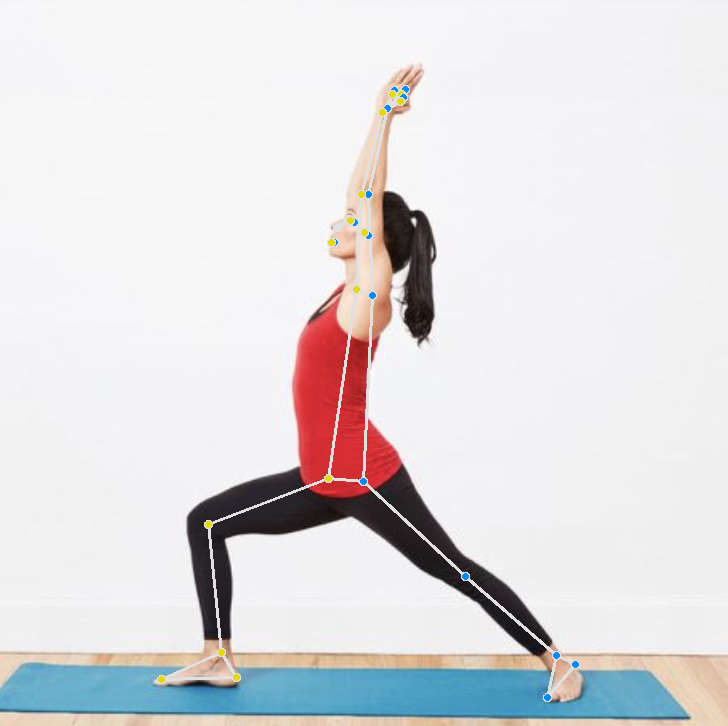

In [15]:
annotate_image("./warrior_pose.jpg")